# Flight delays

The task is to predict whether a flight will be delayed for more than 15 minutes.

In [190]:
import warnings
import numpy as np
import pandas as pd

Read the data for training and testing

In [191]:
train_data = pd.read_csv('./flight_delays_train.csv')
test_data = pd.read_csv('./flight_delays_test.csv')

In [192]:
train_data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Replace Yes and No in target feature (wether the plain was delayed or not) with '1's and '0's

In [193]:
train_data.loc[(train_data.dep_delayed_15min == 'Y'), 'dep_delayed_15min'] = 1
train_data.loc[(train_data.dep_delayed_15min == 'N'), 'dep_delayed_15min'] = 0

# EDA

Make Month, DayOfMonth and DayOfWeek fatures integers (also get rid of the prefix 'c-' )

In [194]:
train_data.Month = train_data.Month.str.slice(start=2).astype(int)
train_data.DayofMonth = train_data.DayofMonth.str.slice(start=2).astype(int)
train_data.DayOfWeek = train_data.DayOfWeek.str.slice(start=2).astype(int)

Plot some coutplots of the mentioned features. As can be seen from the bottomn row of hists, there are little to no dependence of the flight delays on the Month/Day (althought there are more delays in the summer months and months with big holidays.)

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

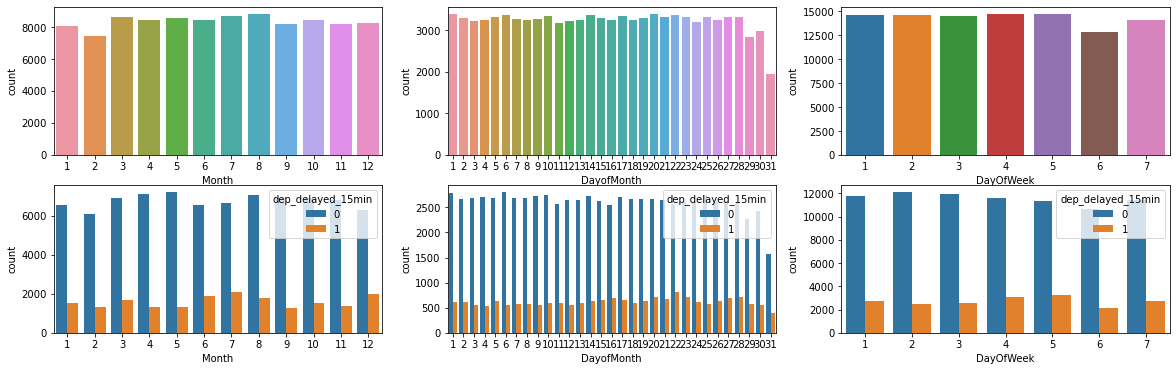

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns

fi, ax = plt.subplots(2,3, figsize = (20,6))
sns.countplot(x = 'Month' , data = train_data, ax = ax[0][0]);
sns.countplot(x = 'Month', data = train_data, hue= 'dep_delayed_15min',ax = ax[1][0])
sns.countplot(x = 'DayofMonth' , data = train_data, ax = ax[0][1]);
sns.countplot(x = 'DayofMonth', data = train_data, hue= 'dep_delayed_15min',ax = ax[1][1])
sns.countplot(x = 'DayOfWeek' , data = train_data, ax = ax[0][2]);
sns.countplot(x = 'DayOfWeek', data = train_data, hue= 'dep_delayed_15min',ax = ax[1][2])

<AxesSubplot:xlabel='Month', ylabel='dep_delayed_15min'>

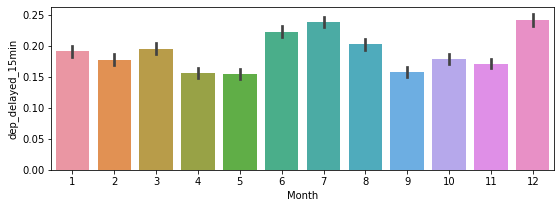

In [196]:
plt.figure(figsize=(9,3))
sns.barplot(x = 'Month', y = 'dep_delayed_15min',
            data = train_data)

<AxesSubplot:xlabel='UniqueCarrier', ylabel='dep_delayed_15min'>

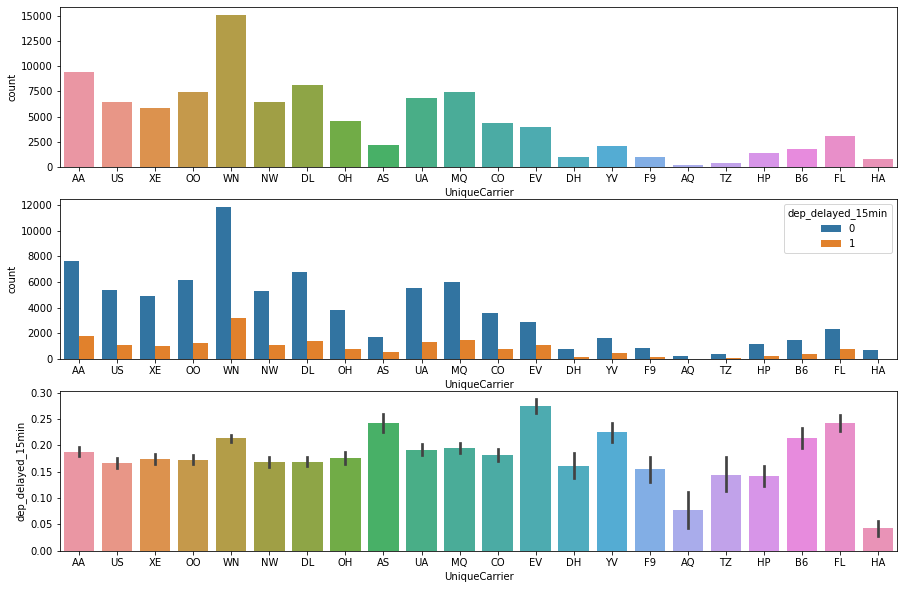

In [197]:
fig, ax = plt.subplots (3,1, figsize = (15,10))
sns.countplot(x = 'UniqueCarrier', data = train_data, ax = ax[0])
sns.countplot(x = 'UniqueCarrier', data = train_data, hue = 'dep_delayed_15min', ax = ax[1])
sns.barplot(x = 'UniqueCarrier', y = 'dep_delayed_15min', data = train_data, ax = ax[2])

# New features

Extract some new features. "Flight" feature describes the trajectory of the flight

In [198]:
train_data['flight'] = train_data['Origin'] +  train_data['Dest']
test_data['flight'] = test_data['Origin'] +  test_data['Dest']

Separate "Departure time" to two features: hours and minutes

In [199]:
train_data['hour'] = train_data['DepTime']//100
train_data.loc[(train_data['hour']==24),'hour']=0
train_data.loc[(train_data['hour']==25),'hour']=1
train_data['minute'] = train_data['DepTime']%100
test_data['hour'] = test_data['DepTime']//100
test_data.loc[(test_data['hour']==24),'hour']=0
test_data.loc[(test_data['hour']==25),'hour']=1
test_data['minute'] = test_data['DepTime']%100

Divide Months into seasons

In [200]:
train_data['winter'] = train_data['Month'].isin([12,1,2]).astype(np.int)
train_data['spring'] = train_data['Month'].isin([3,4,5]).astype(np.int)
train_data['summer'] = train_data['Month'].isin([6,7,8]).astype(np.int)
train_data['autumn'] = train_data['Month'].isin([9,10,11]).astype(np.int)

In [201]:
test_data['winter'] = test_data['Month'].isin([12,1,2]).astype(np.int)
test_data['spring'] = test_data['Month'].isin([3,4,5]).astype(np.int)
test_data['summer'] = test_data['Month'].isin([6,7,8]).astype(np.int)
test_data['autumn'] = test_data['Month'].isin([9,10,11]).astype(np.int)

Divide data into training and testing categories

In [202]:
y_train = train_data['dep_delayed_15min']
X_train = train_data.drop('dep_delayed_15min', axis=1)

In [177]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
X_train, X_holdout, y_train, y_holdout =  train_test_split(X_train, y_train, test_size=0.3, random_state = 17)

# Model, parameter tuning

In [15]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

At first we will be using CatBoost for classification. 

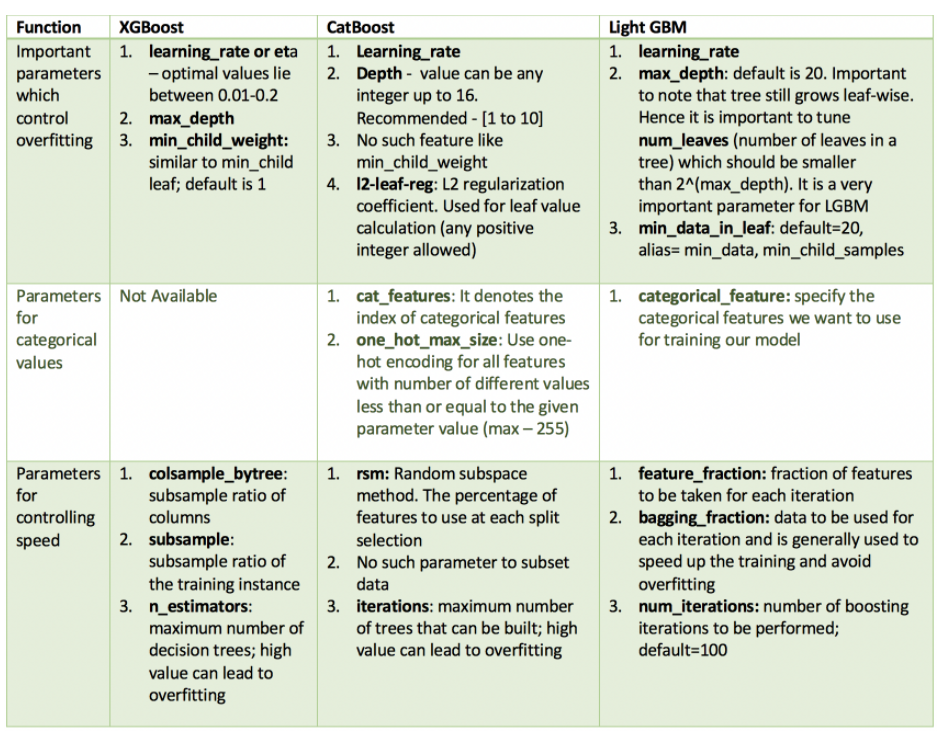

In [16]:
%%time
model_cat = CatBoostClassifier(iterations=500         ,
                               loss_function='Logloss',
                               l2_leaf_reg=100        ,
                               #border_count = 200     ,
                               learning_rate= 0.1     ,
                               random_seed=17         , 
                               depth = 5              , 
                               silent=True            )
model_cat.fit(X_train, y_train.astype(int), cat_features=[ 0,1,2,4, 5, 6, 8, 11, 12, 13, 14])

Wall time: 1min 5s


Some of the parameters of CatBoost:


loss_function alias as objective — Metric used for training. These are regression metrics such as root mean squared error for regression and logloss for classification.

iterations — The maximum number of trees to be built, defaults to 1000. It aliases are num_boost_round, n_estimators, and num_trees.

learning_rate alias eta — The learning rate that determines how fast or slow the model will learn. The default is usually 0.03.

random_seed alias random_state — The random seed used for training.

l2_leaf_reg alias reg_lambda — Coefficient at the L2 regularization term of the cost function. The default is 3.0.

score_function — The score type used to select the next split during tree construction. Cosine is the default option. The other available options are L2, NewtonL2, and NewtonCosine.

early_stopping_rounds — When True, sets the overfitting detector type to Iter and stops the training when the optimal metric is achieved.

cat_features — The array with the categorical columns.


In [17]:
from sklearn.metrics import roc_auc_score
accuracy = roc_auc_score(y_holdout.astype(int),model_cat.predict_proba(X_holdout)[:,1])
print ('Accuracy holdout data: {}'.format(accuracy))
print ('Accuracy training data: {}'.format(roc_auc_score(y_train.astype(int),model_cat.predict_proba(X_train)[:,1])))

Accuracy holdout data: 0.7585230720574156
Accuracy training data: 0.8700037868613346


First step of parameter tuning. We first search border_count while leaving everything else default. Then we search ctr_border_count using the best of the parameters we found previously. When we get to iterations and learning_rate we grid search these together (test all possible combinations of the two). After that we find the best depth. Once we have tested all these parameter combinations we just have to call catBoostClassifier with the best one.

In [22]:
params = {#'depth':[3,1,6,5,7,10],
          'iterations':[500,1000],
          'learning_rate':[0.01,0., 0.2], 
          #'l2_leaf_reg':[3,1,5,10,100],
          #'border_count':[32,5,10,20,50,100,200],
          #'thread_count':4
}

In [23]:
skf = StratifiedKFold(n_splits=5, random_state=17, shuffle=True)
grid_search = GridSearchCV(model_cat, param_grid= params, cv=skf, verbose=1, n_jobs=-1)

In [212]:
grid_search.fit(X_train, y_train.astype(int), cat_features=[ 0,1,2,4, 5, 6, 8, 11, 12, 13, 14])

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 14.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000011CACCC3B80>,
             n_jobs=-1,
             param_grid={'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.0, 0.2]},
             verbose=1)

In [132]:
grid_search.best_params_

{'border_count': 200}

In [145]:
grid_search.best_params_

{'iterations': 500, 'learning_rate': 0.1}

In [151]:
grid_search.best_params_

{'l2_leaf_reg': 100}

In [162]:
grid_search.best_params_

{'depth': 5}

In [168]:
grid_search.best_estimator_

In [213]:
accuracy = roc_auc_score(y_holdout.astype(int),grid_search.best_estimator_.predict_proba(X_holdout)[:,1])
accuracy


0.7498086644495595

In [214]:
fetures_imp = pd.DataFrame({'feat': X_train.columns,
                           'coef' : model_cat.feature_importances_}).sort_values(by = 'coef',ascending = False)
print (fetures_imp)

             feat       coef
3         DepTime  34.075845
9            hour  17.089039
5          Origin   7.746775
4   UniqueCarrier   7.562821
7        Distance   6.216514
6            Dest   5.896476
0           Month   4.972658
10         minute   4.843486
2       DayOfWeek   4.291909
1      DayofMonth   4.208058
8          flight   1.748676
11         winter   0.572141
13         summer   0.384479
12         spring   0.237522
14         autumn   0.153601


Departure Time is the most important feature

# LGBMClassifier (GridSearch vs Baysian opt)

In [225]:
clf = lgb.LGBMClassifier(random_state=7,
                         iterations = 300,
                         learning_rate=0.1, 
                         loss_function = 'logloss',
                         l2_leaf_reg = 3,
                         grow_policy = 'Lossquide', 
                         depth = 3, 
                         max_leaves = 7,
                         feature_fraction = 1)
# Categorical columns
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'UniqueCarrier', 'hour', 'summer', 'autumn', 'winter', 'spring','flight']

# Converting categorical columns to type 'category' as required by LGBM
for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
for c in cat_cols:
    test_data[c] = test_data[c].astype('category')


Firstly try to use GridSearch as was performed before on CatBoost

In [19]:
params_lgb = {#'depth':[3,1,6,5],
              #'max_leaves': [7,1,31]
          #'iterations':[300, 400,500],
          #'learning_rate':[0.01,0.1], 
          #'l2_leaf_reg':[3,1,5,10,100]
           'feature_fraction': [0.1,1],
}

In [24]:
grid_search_lgb = GridSearchCV(clf, param_grid= params_lgb, cv=skf, verbose=1, n_jobs=-1)

In [25]:
clf.fit(X_train, y_train.astype(int))

[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: grow_policy
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] num_leaves is set=31, max_leaves=7 will be ignored. Current value: num_leaves=31


LGBMClassifier(depth=3, feature_fraction=1, grow_policy='Lossquide',
               iterations=300, l2_leaf_reg=3, loss_function='logloss',
               max_leaves=7, random_state=7)

In [27]:
accuracy = roc_auc_score(y_holdout.astype(int),clf.predict_proba(X_holdout)[:,1])
accuracy

0.714559737381515

The accuracy dropped in comparison to CatBoost --> try baysian optimisation

# Baysian Optimization

(*for this part I was mostly using examples from this kernels: https://www.kaggle.com/fayzur/lgb-bayesian-parameters-finding-rank-average ; https://www.kaggle.com/sz8416/simple-bayesian-optimization-for-lightgbm ; https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm *)

Bayesian Optimization is a probabilistic model based approach for finding the minimum of any function that returns a real-value metric. This optimization attempts to find the maximum value of an black box function in as few iterations as possible.

It is very effective with real-world applications in high-dimensional parameter-tuning for complex machine learning algorithms. Bayesian optimization utilizes the Bayesian technique of setting a prior over the objective function and combining it with evidence to get a posterior function.

hyperparameter tuning by Bayesian Optimization of machine learnin models is more efficient than Grid Search and Random Search. Bayesian Optimization has better overall performance on the test data and takes less time for optimization. Also, we do not need to set a certain values of parameters like we do in Random Search and Grid Search. For Bayesian Optimization tuning, we just give a range of a hyperparameter.

In [33]:
from bayes_opt import BayesianOptimization

In [146]:
target = 'dep_delayed_15min'

predictors = train_data.columns.values.tolist()[2:]
train_data.dep_delayed_15min.value_counts() # to see if target feature is unbalanced

0    80956
1    19044
Name: dep_delayed_15min, dtype: int64

In [213]:
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'UniqueCarrier', 'hour', 'summer', 'autumn', 'winter', 'spring','flight']

# Converting categorical columns to type 'category' as required by LGBM
for c in cat_cols:
    train_data[c] = train_data[c].astype('category')
    test_data[c] = test_data[c].astype('category')


In [161]:
bay_tr_ix, bay_val_ix = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=7).split(train_data, train_y.values.astype(int)))[0]

50% Stratified rows as holdout rows for the validation-set to get optimal parameters. These bayesian_tr_index and bayesian_val_index indexes will be used for the bayesian optimization as training and validation index of training dataset.

In [183]:

def LGB_bayesian(num_leaves, min_data_in_leaf, learning_rate, min_sum_hessian_in_leaf, feature_fraction, lambda_l1,
                 lambda_l2, min_gain_to_split, max_depth):
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    params = {
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_data_in_leaf': min_data_in_leaf,
        'min_gain_to_split': min_gain_to_split,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
           'num_leaves': num_leaves,
        'max_bin': 255,
        'bagging_fraction': 0.8,
        'bagging_freq': 6,
        'save_binary': True,
        'seed': 7,
        'feature_fraction_seed': 7,
        'bagging_seed': 7,
        'drop_seed': 7,
        'data_random_seed': 7,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': True,
        'n_jobs': -1
    }


    lgb_train = lgb.Dataset(train_data.loc[bay_tr_ix], y_train.loc[bay_tr_ix].astype(int), free_raw_data=False)
    lgb_valid = lgb.Dataset(train_data.loc[bay_val_ix], y_train.loc[bay_val_ix].astype(int), free_raw_data=False)
    
    
    num_rounds=5000
    clf = lgb.train(params, lgb_train, num_rounds, valid_sets=[lgb_train, lgb_valid], verbose_eval=250, early_stopping_rounds=50)
    val_preds = clf.predict(train_data.loc[bay_val_ix], num_iterations=clf.best_iteration)
    
    score = roc_auc_score(y_train.loc[bay_val_ix].astype(int), val_preds)
    return score


The above LGB_bayesian function will act as black box function for Bayesian optimization. I already defined the the trainng and validation dataset for LightGBM inside the LGB_bayesian function.

The LGB_bayesian function takes values for num_leaves, min_data_in_leaf, learning_rate, min_sum_hessian_in_leaf, feature_fraction, lambda_l1, lambda_l2, min_gain_to_split, max_depth from Bayesian optimization framework. 

num_leaves, min_data_in_leaf, and max_depth should be integer for LightGBM. But Bayesian Optimization sends continous vales to function. So force them to be integer. 

Now give bounds for these parameters, so that Bayesian optimization only search inside the bounds.

In [184]:
bounds_lgb = {
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0., 10.),
    'lambda_l2': (0., 10.),
    'learning_rate': (0.01, 0.1),
    'max_depth': (2, 8),
    'min_data_in_leaf': (5, 30),
    'min_gain_to_split': (0, 1),
    'min_sum_hessian_in_leaf': (0.01, 1),
    'num_leaves': (10, 35)
}

Let's put all of them in BayesianOptimization object

In [185]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_lgb, random_state=7)

I have created the BayesianOptimization object (LGB_BO). It will not work until maximize is called. two parameters of BayesianOptimization object (LGB_BO) which should be passed to maximize:

init_points: How many initial random runs of random exploration we want to perform. In our case LGB_bayesian will be called n_iter times.


n_iter: How many runs of bayesian optimization we want to perform after number of init_points runs.
Now, it's time to call the function from Bayesian optimization framework to maximize. 

In [186]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=10, n_iter=10, acq='ucb')   

#n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum.
#init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 13379, number of negative: 56621
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4959
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191129 -> initscore=-1.442694
[LightGBM] [Info] Start training from score -1.442694
Training until validation scores don't i

In [187]:
LGB_BO.max['target']

0.7249227437480403

In [188]:
LGB_BO.max['params']

{'feature_fraction': 0.5,
 'lambda_l1': 5.6804355018303845,
 'lambda_l2': 10.0,
 'learning_rate': 0.01,
 'max_depth': 8.0,
 'min_data_in_leaf': 30.0,
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 1.0,
 'num_leaves': 35.0}

# Training LightGBM model

In [189]:
params = {
    'feature_fraction': LGB_BO.max['params']['feature_fraction'],  
    'lambda_l1': LGB_BO.max['params']['lambda_l1'],
    'lambda_l2': LGB_BO.max['params']['lambda_l2'],
    'learning_rate': LGB_BO.max['params']['learning_rate'],
    'max_depth': int(np.round(LGB_BO.max['params']['max_depth'])),
    'min_data_in_leaf': int(np.round(LGB_BO.max['params']['min_data_in_leaf'])),# remember to int here
    'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
    'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
    'num_leaves': int(np.round(LGB_BO.max['params']['num_leaves'])),# remember to int here
    'max_bin': 255,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'save_binary': True,
    'seed': 7,
    'feature_fraction_seed': 7,
    'bagging_seed': 7,
    'drop_seed': 7,
    'data_random_seed': 7,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'auc',
    'is_unbalance': True,
    'boost_from_average': True,
    'n_jobs': -1
}

In [206]:
nfold = 5

In [207]:
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

In [215]:
def test_kfold(params, train_df, train_y, test_df, cv):
    test_preds = 0.
    valid_preds = np.zeros(train_y.shape)
    
    for fold, (train_ix, valid_ix) in enumerate(cv.split(train_data, train_y.astype(int))):
        print(f"\nFOLD: {fold+1} {'='*50}")
        X_train, X_valid = train_df.iloc[train_ix], train_df.iloc[valid_ix]
        y_train, y_valid = train_y.iloc[train_ix], train_y.iloc[valid_ix]
        
        lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
        lgb_valid = lgb.Dataset(X_valid, y_valid, free_raw_data=False)
        
        clf = lgb.train(params, lgb_train, 5000, valid_sets=[lgb_train, lgb_valid], verbose_eval=250, early_stopping_rounds=50)
        valid_preds[valid_ix] = clf.predict(train_df.iloc[valid_ix], num_iterations=clf.best_iteration)
        test_preds += clf.predict(test_df, num_iterations=clf.best_iteration)
    
    print(f'Valid CV: {roc_auc_score(train_y, valid_preds)}')
    test_preds /= cv.n_splits
    
    return test_preds

In [227]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')    
    test_preds = test_kfold(params, X_train, y_train.astype(int), test_data, StratifiedKFold(n_splits=5, random_state=7, shuffle=True))


FOLD: 1 ==================================================
[LightGBM] [Info] Number of positive: 15236, number of negative: 64764
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5036
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.190450 -> initscore=-1.447089
[LightGBM] [Info] Start training from score -1.447089
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG